# ASTR 496: Foundations of Data Science in Astronomy
# Fitting a Stellar Binary Orbit with MCMC using `emcee`
### Gautham Narayan

## Introduction

You are going to use Markov Chain Monte Carlo (MCMC) to fit the radial velocity curve of a binary star system. This is a fairly common problem in astrophysics where we observe the Doppler shift of spectral lines as stars orbit their common center of mass. You've already modeled a transit for an exoplanet light curve, so might as well model the other common method to find them.


I'll give you the physical setup - 

A binary star system with one visible component shows periodic radial velocity variations:

$$v_r(t) = K \sin\left(\frac{2\pi(t - t_0)}{P}\right) + v_0$$

where:
- $K$ = velocity semi-amplitude (km/s)
- $P$ = orbital period (days)
- $t_0$ = time of periastron passage (days)
- $v_0$ = systemic velocity (km/s)

In [17]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import stats
# import whatever else you want here

# Set random seed for reproducibility
np.random.seed(42) # the answer to Life, the Universe, Everything
# i live in apartment number 42 for this exact reason - varun

# Plotting style
#%matplotlib ipympl

### Next, I'll create synthetic observations of a binary star system with known parameters, then add observational noise.

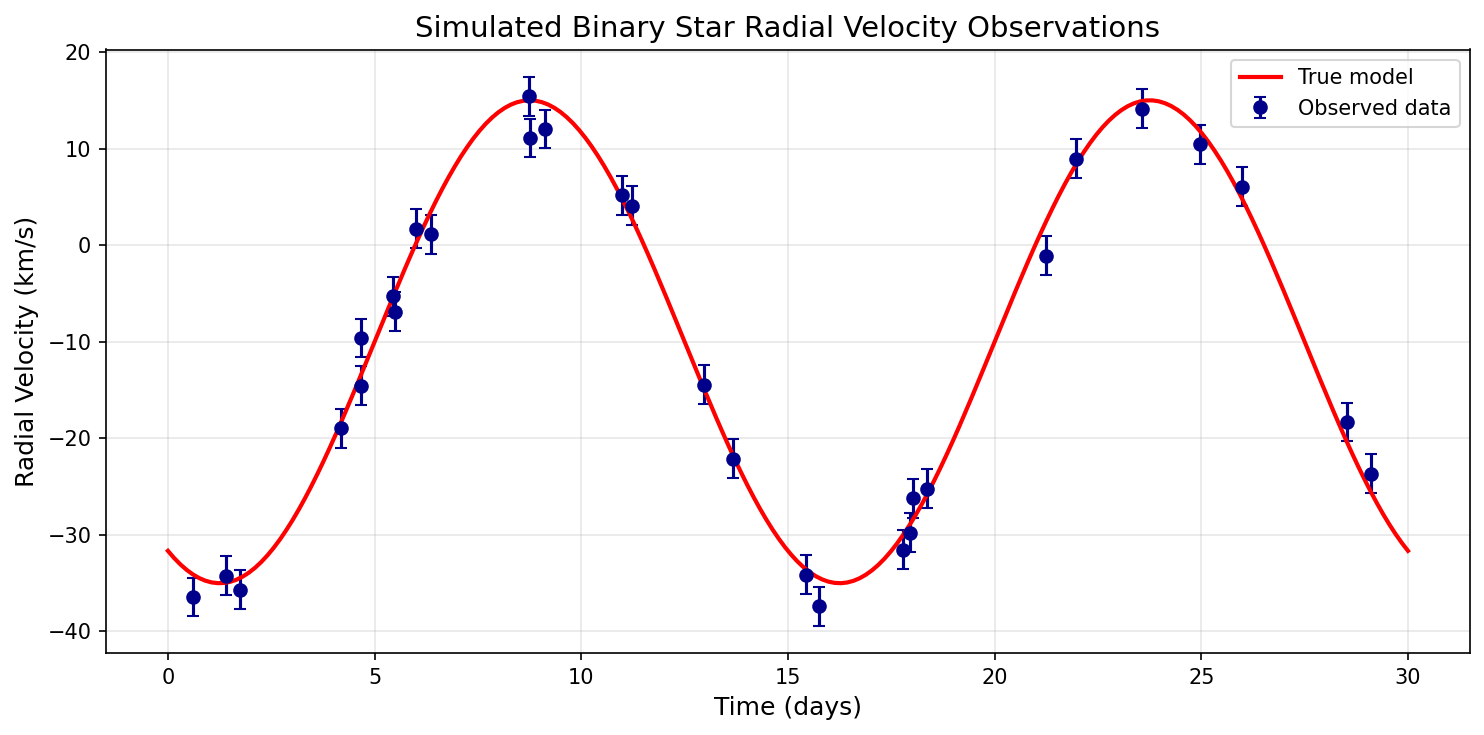

True parameters:
  K  = 25.0 km/s
  P  = 15.0 days
  t0 = 5.0 days
  v0 = -10.0 km/s


In [18]:
# True parameters (these are what we'll try to recover)
K_true = 25.0      # km/s
P_true = 15.0      # days
t0_true = 5.0      # days
v0_true = -10.0    # km/s

# Observation setup
n_obs = 30
t_obs = np.sort(np.random.uniform(0, 30, n_obs))  # Random times over 30 days
v_err = 2.0  # Measurement uncertainty (km/s)

# Model function
def radial_velocity_model(t, K, P, t0, v0):
    """Calculate radial velocity at time t for circular orbit"""
    phase = 2 * np.pi * (t - t0) / P
    return K * np.sin(phase) + v0

# Generate true signal
v_true = radial_velocity_model(t_obs, K_true, P_true, t0_true, v0_true)

# Add Gaussian noise
v_obs = v_true + np.random.normal(0, v_err, n_obs)

# Plot the data
plt.figure(figsize=(10, 5),dpi=150)
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observed data', 
             color='darkblue', markersize=6, capsize=3)
t_model = np.linspace(0, 30, 200)
v_model = radial_velocity_model(t_model, K_true, P_true, t0_true, v0_true)
plt.plot(t_model, v_model, 'r-', label='True model', linewidth=2)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Radial Velocity (km/s)', fontsize=12)
plt.title('Simulated Binary Star Radial Velocity Observations', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"True parameters:")
print(f"  K  = {K_true:.1f} km/s")
print(f"  P  = {P_true:.1f} days")
print(f"  t0 = {t0_true:.1f} days")
print(f"  v0 = {v0_true:.1f} km/s")

### OK now for the homework:

For MCMC, we need to define:
1. **Log-likelihood**: How well does a model fit the data?
2. **Log-prior**: What do we know before seeing the data?
3. **Log-posterior**: Combination of likelihood and prior (what we sample)

In [19]:
def log_likelihood(theta, t, v, v_err):
    """
    Calculate the log-likelihood of the model given the data.
    Remember
    theta : array
        Model parameters [K, P, t0, v0]
    t : array
        Observation times
    v : array
        Observed velocities
    v_err : float
        Measurement uncertainty
    """
    K, P, t0, v0 = theta
    v_model = radial_velocity_model(t, K, P, t0, v0)
    chi2 = np.sum(((v - v_model) / v_err) ** 2)
    return -0.5 * (chi2 + np.sum(np.log(2 * np.pi * v_err**2)))

def log_prior(theta):
    """
    Returns -inf if parameters are outside allowed ranges.
    """
    K, P, t0, v0 = theta
    if (K <= 0) or (K >= 100):
        return -np.inf
    if (P <= 0.1) or (P >= 100):
        return -np.inf
    if (t0 <= 0) or (t0 >= 30):
        return -np.inf
    if (v0 <= -50) or (v0 >= 50):
        return -np.inf
    
    return 0.

def log_probability(theta, t, v, v_err):
    """
    Calculate the log-posterior probability.

    """
    lp = log_prior(theta)
    if lp == -np.inf:
        return -np.inf
    return lp + log_likelihood(theta, t, v, v_err)

#### Justify the choice of prior in a few sentences

The priors I used are just a flat range of values, and I used these values as physically and astronomically sensible. These are just guesses based on values I thought made sense, but if I had previous data, I could have made a more educated guess.

#### Describe how you treated the uncertainties in a few sentences

Like the first HW, I treated the errors as Gaussian in the chi squared equation. In this assumption, I take that the `v_err` is the entire observational noise.



#### Next setup the MCMC. 

Use the affine-invariant ensemble sampler from `emcee`. This requires:
- Initial positions for multiple "walkers" (independent MCMC chains)
- Number of steps to run

**Rule of thumb**: Use at least 2×(number of parameters) walkers.

In [20]:
# MCMC setup
ndim = 4
nwalkers = 32
nsteps = 5000

# Set some initial positions for the walkers - I'd suggest adding small random scatter around a guess
# you can get your guess from scipy.optimize or just making something up.

init = np.array([K_true, P_true, t0_true, v0_true])
pos = init + 1e-3 * init * np.random.randn(nwalkers, ndim)

#### Run the MCMC Sampler
This may take a minute or two.

In [21]:
# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t_obs, v_obs, v_err))
# Run MCMC
sampler.run_mcmc(pos, nsteps)

# Print the acceptance fraction from the sampler
acceptance_fraction = sampler.acceptance_fraction
print("Mean acceptance fraction:", np.mean(acceptance_fraction))

Mean acceptance fraction: 0.59696875


#### Analyze the Chains

i.e. heck if the chains have "converged" (reached the posterior distribution).
Do this by plotting the `nsteps` samples from all `nwalkers` chains 

**Key concepts:**

- **Autocorrelation time**: How many steps until samples are independent
- **Burn-in**: Initial steps where walkers move from initial positions to the posterior
- **Thinning**: take every n'th sample from the chains to reduce the autocorrelation


You can look at the slides for notes on this. Make some reasonable choices! Or if you don't have a good sense, you can use a burn-in that is twice the maximum autocorrelation time, and thinning of 1/2 the minimum autocorrelation time. This implies that there are multiple autocorrelation times, and you have to figure out how. 

(5000, 32, 4)


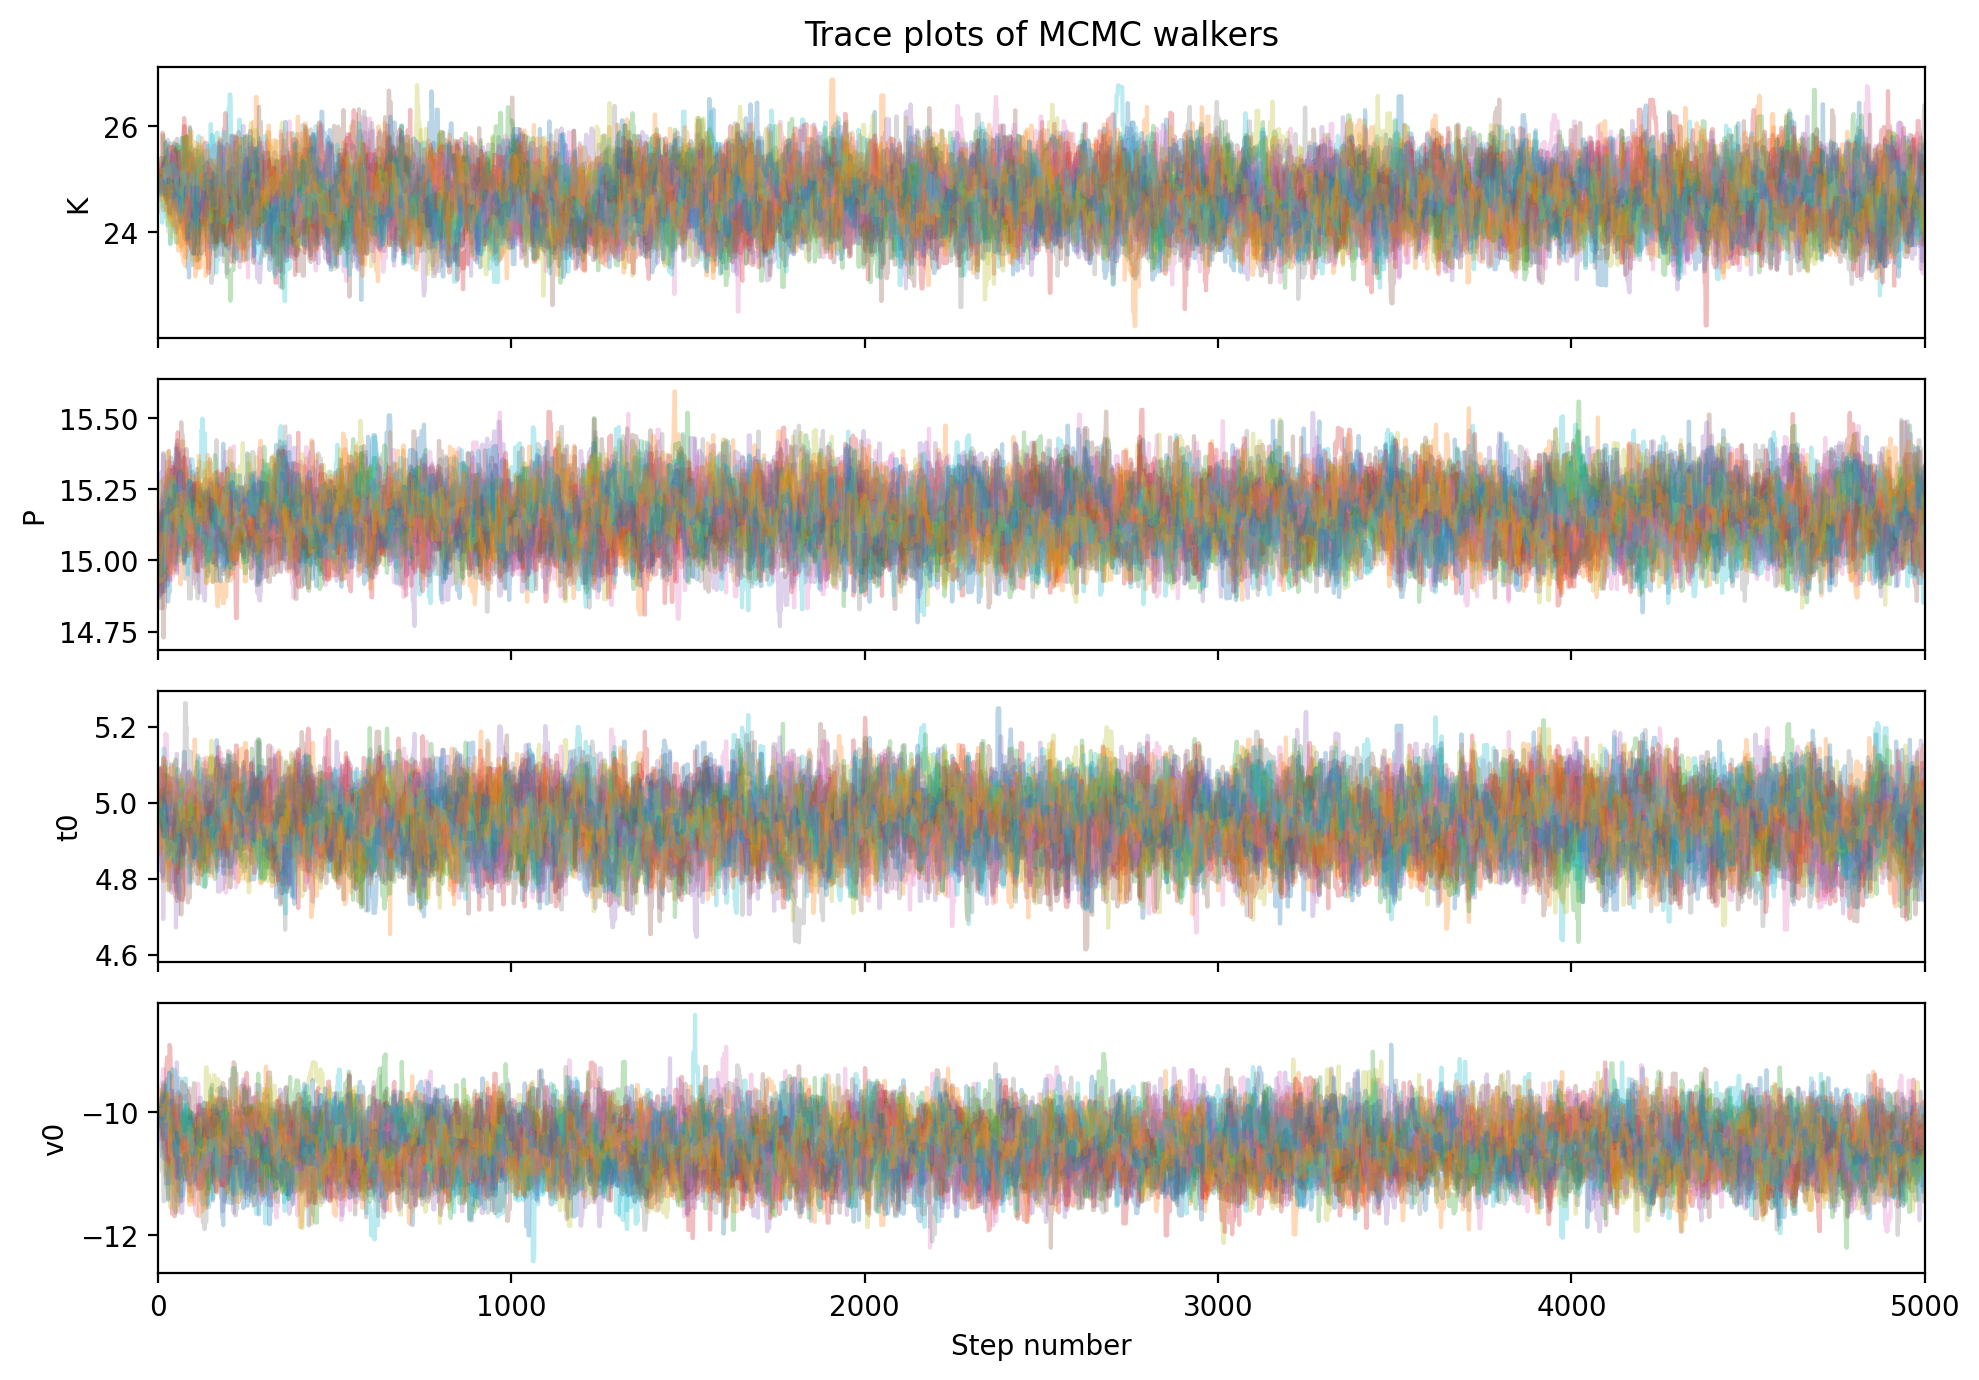

Autocorrelation times: [40.84008082 45.99399036 49.3397617  49.03084209]
Suggested burn-in: 98, thinning: 20


In [22]:
# Plot the chains - and remember to label your plots - you aren't silly first-years
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True,dpi=200)
labels = ["K", "P", "t0", "v0"]
samples = sampler.get_chain()
print(samples.shape)

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, nsteps)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
axes[0].set_title("Trace plots of MCMC walkers", y=1.02)
plt.tight_layout()
plt.show()


# Calculate autocorrelation time
tau = sampler.get_autocorr_time()
print(f"Autocorrelation times: {tau}")
burnin = int(2 * np.max(tau))
thin   = int(0.5 * np.min(tau))
print(f"Suggested burn-in: {burnin}, thinning: {thin}")

#### Extract and Analyze Results

After discarding burn-in, you'll extract the posterior samples and calculate parameter estimates.

In [23]:
# Get flattened samples (discard burn-in and thin)
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print(f"Shape of flattened sample set: {flat_samples.shape}")
# Calculate parameter estimates
labels = ["K", "P", "t0", "v0"]
for i, name in enumerate(labels):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)  # lower and upper errors
    print(f"{name} = {mcmc[1]:.3f} (+{q[1]:.3f}, -{q[0]:.3f})")

Shape of flattened sample set: (7840, 4)
K = 24.626 (+0.543, -0.499)
P = 15.153 (+0.098, -0.092)
t0 = 4.949 (+0.073, -0.078)
v0 = -10.568 (+0.403, -0.399)


#### Create a Corner Plot

A corner plot shows all 1D and 2D marginalized distributions, revealing parameter correlations.

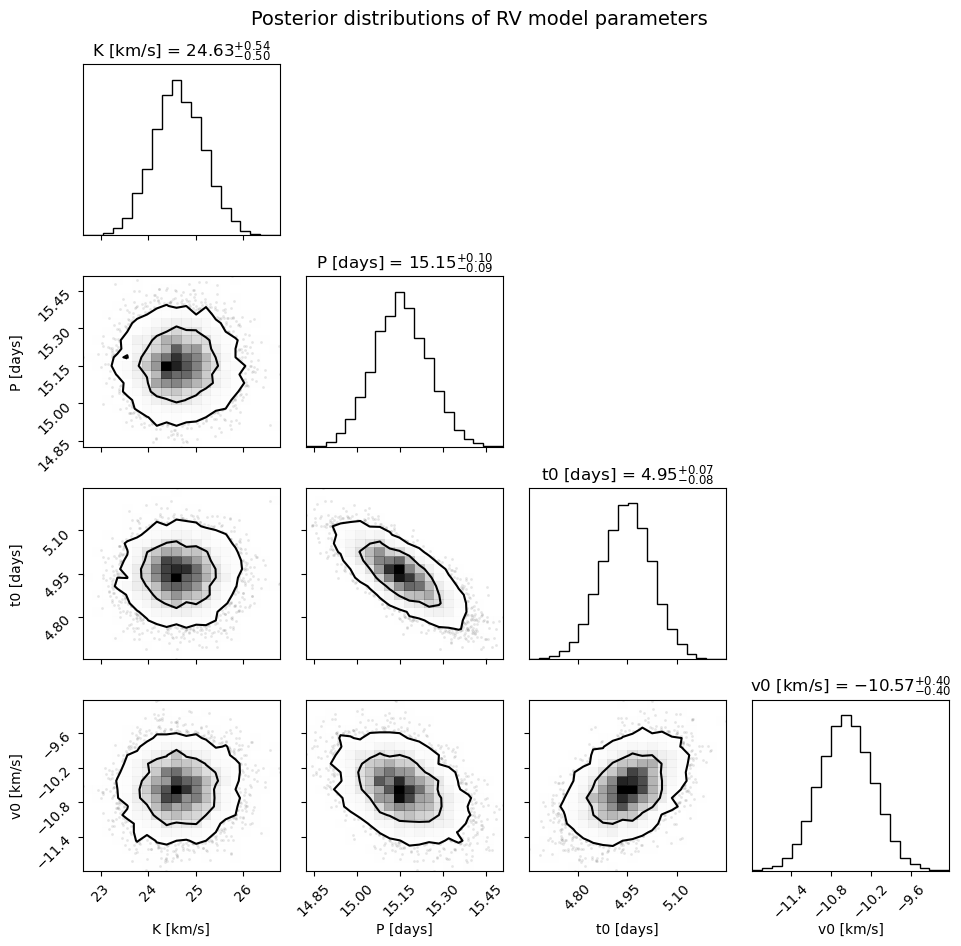

In [26]:
# you can use the corner package 
labels = ["K [km/s]", "P [days]", "t0 [days]", "v0 [km/s]"]
fig = corner.corner(
    flat_samples,
    labels=labels,
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    plot_datapoints=True,
    levels=(0.68, 0.95),
    dpi = 200
)
plt.suptitle("Posterior distributions of RV model parameters", fontsize=14)
plt.tight_layout()
plt.show()

#### Plot the Best-Fit Model
LOOK AT YOUR DATA. Take the median estimate to be the "best-fit"
Plot some confidence interval

Best-fit parameters (median):
K  = 24.6 km/s
P  = 15.2 days
t0 = 4.9 days
v0 = -10.6 km/s


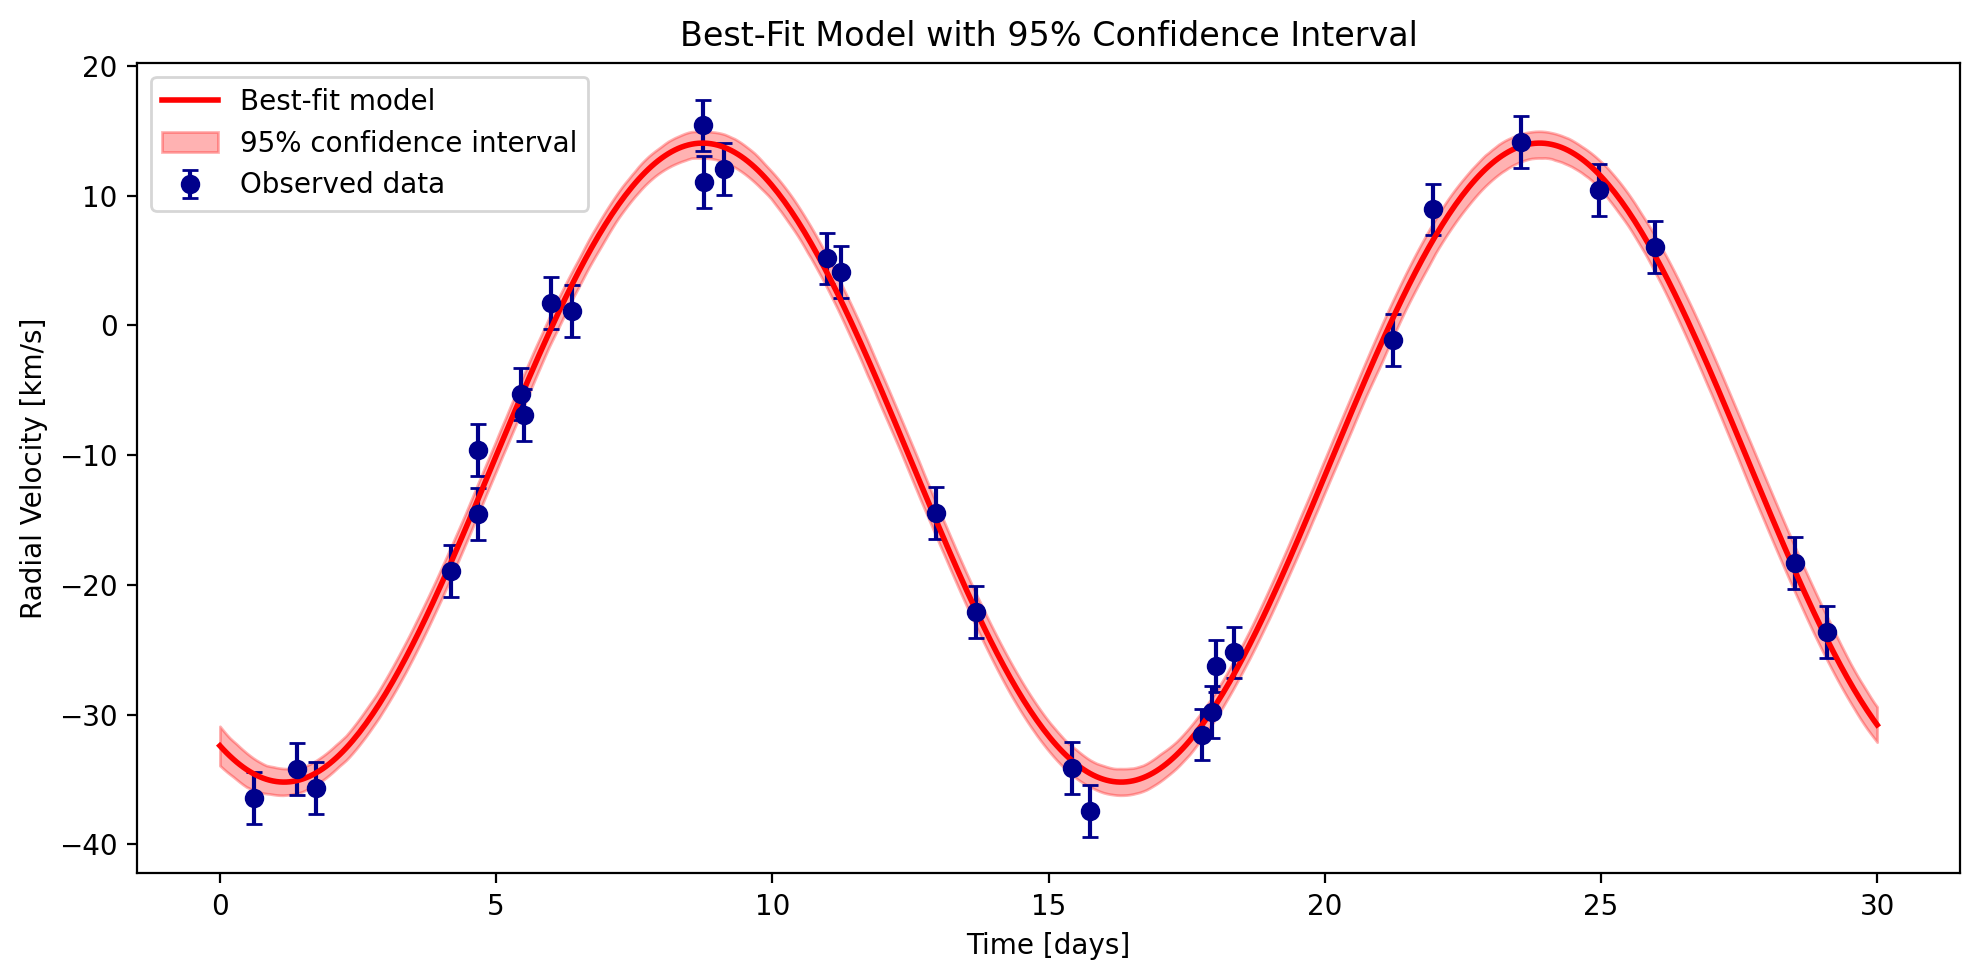

In [27]:
# also plot the true model - you can look at the simulation code
best_fit = np.median(flat_samples, axis=0)
K_fit, P_fit, t0_fit, v0_fit = best_fit
print("Best-fit parameters (median):")
print(f"K  = {K_fit:.1f} km/s")
print(f"P  = {P_fit:.1f} days")
print(f"t0 = {t0_fit:.1f} days")
print(f"v0 = {v0_fit:.1f} km/s")

t_plot = np.linspace(0, 30, 500)
v_model_best = radial_velocity_model(t_plot, K_fit, P_fit, t0_fit, v0_fit)

idx = np.random.choice(flat_samples.shape[0], size=200, replace=False)
v_samples = np.array([radial_velocity_model(t_plot, *flat_samples[i]) for i in idx])

v_lower = np.percentile(v_samples, 5, axis=0)
v_upper = np.percentile(v_samples, 95, axis=0)

plt.figure(figsize=(10, 5), dpi=200)
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', color='darkblue', label='Observed data', capsize=3)
plt.plot(t_plot, v_model_best, 'r-', lw=2, label='Best-fit model')
plt.fill_between(t_plot, v_lower, v_upper, color='r', alpha=0.3, label='95% confidence interval')
plt.xlabel("Time [days]")
plt.ylabel("Radial Velocity [km/s]")
plt.title("Best-Fit Model with 95% Confidence Interval")
plt.legend()
plt.tight_layout()
plt.show()


Finally, again a few sentences here:

**Correlations**: Examine the corner plot. Are any parameters correlated? Why might K and v₀ show correlation?

From the corner plot, it appears that P and t0, and P and v0 are roughly correlated. t0 and v0 also appears to show a weak correlation.

**Uncertainty**: Compare the posterior uncertainties to the true values. Did our MCMC analysis recover the true parameters within the error bars?

The MCMC analysis did not recover all parameters within error bars. This could be due to insufficient sampling, or a poor initialization.

**Sensitivity**: What happens if you increase the measurement uncertainty (`v_err`)? Try changing it to 10.0 km/s and rerun.

The image I get is the following: 

![Image with v_err = 10](output.png "Output with v_err = 10")

From this, we see that uncertainties significantly increase, and you get a much lower S/N ratio. 

**Sampling**: What would happen if you used too few walkers (e.g., nwalkers=4)? Too few steps?


If i use too few walkers (`nwalkers = 4`), i get the following error: `ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance`

Increacing it to `nwalkers = 6`, I get this error `RuntimeError: It is unadvisable to use a red-blue move with fewer walkers than twice the number of dimensions.`

Increasing it by a bit more to 2 * `ndim`, I get this plot 

![Image with nwalkers = 8](output2.png "Output with nwalkers = 8")

Too few walkers reduce the ensemble diversity, which leads to a lower exploration of the parameter space, so the posterior may not be reached. The corner plots for these also look very scattered, and do not show smoother contour levels.
